In [1]:
PROJECT_PATH = "/content/drive/My Drive/Deep_Learning_Assignments/Project/"
%cd "{PROJECT_PATH}"
!pip install livelossplot>/tmp/xxy
!pip install timm>/tmp/xxy
!pip install neptune-client>/tmp/xxy
%env NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiM2UwMDkxZmItNDhlMi00MjEzLTkxMTAtYzBiOWQxNzk2MjUyIn0="

/content/drive/My Drive/Deep_Learning_Assignments/Project
env: NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiM2UwMDkxZmItNDhlMi00MjEzLTkxMTAtYzBiOWQxNzk2MjUyIn0="


In [2]:
!nvidia-smi

Fri Mar 20 11:18:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Imports


In [3]:
# %reload_ext plotcm

import torch
import torchvision
from torchvision.models import resnet18, densenet201, densenet121
from torchvision.transforms import transforms
import pandas as pd
import torch.nn as nn
from tqdm.auto import tqdm as tq
import torch.optim as optim

from plotcm import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from livelossplot import PlotLosses
import numpy as np
import pandas as pd
import neptune
from timm import create_model

if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')

neptune.init('rohanrajpal/DLproject')

Project(rohanrajpal/DLProject)

# Dataset

In [0]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0].split('/')[-1][:-4]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

# Helper

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler


def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           show_sample=False,
                           num_workers=4,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    # normalize = transforms.Normalize(
    #     mean=[0.4914, 0.4822, 0.4465],
    #     std=[0.2023, 0.1994, 0.2010],
    # )
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    # define transforms
    valid_transform = transforms.Compose([
            transforms.Resize([224, 224]),
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.Resize([224, 224]),
            transforms.RandomRotation(30),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomAffine(45),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize([224, 224]),
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    # train_dataset = datasets.CIFAR10(
    #     root=data_dir, train=True,
    #     download=True, transform=train_transform,
    # )
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_dir,
        transform=train_transform
    )
    print(train_dataset.class_to_idx)
    # valid_dataset = datasets.CIFAR10(
    #     root=data_dir, train=True,
    #     download=True, transform=valid_transform,
    # )
    valid_dataset = torchvision.datasets.ImageFolder(
        root=data_dir,
        transform=valid_transform
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images
    # if show_sample:
    #     sample_loader = torch.utils.data.DataLoader(
    #         train_dataset, batch_size=9, shuffle=shuffle,
    #         num_workers=num_workers, pin_memory=pin_memory,
    #     )
    #     data_iter = iter(sample_loader)
    #     images, labels = data_iter.next()
    #     X = images.numpy().transpose([0, 2, 3, 1])
    #     plot_images(X, labels)

    return (train_loader, valid_loader)


def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True,
                    num_workers=4,
                    pin_memory=False):
    """
    Utility function for loading and returning a multi-process
    test iterator over the CIFAR-10 dataset.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - shuffle: whether to shuffle the dataset after every epoch.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - data_loader: test set iterator.
    """
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
    # normalize = transforms.Normalize(
    #     mean=[0.4914, 0.4822, 0.4465],
    #     std=[0.2023, 0.1994, 0.2010],
    # )

    # define transform
    transform = transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        normalize,
    ])

    # dataset = datasets.CIFAR10(
    #     root=data_dir, train=False,
    #     download=True, transform=transform,
    # )
    dataset = ImageFolderWithPaths(
        root=data_dir,
        transform=transform
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    return data_loader

# Dataloader

In [6]:
train_loader, valid_loader = get_train_valid_loader(PROJECT_PATH + "data/train/",batch_size=32,augment=True,
                                                    random_seed=42,valid_size=0.15,shuffle=True,show_sample=False,
                                                    num_workers=4,pin_memory=True)
test_loader = get_test_loader(PROJECT_PATH + "data/test/",32,False,4,True)

# for item in test_loader:
#   print(item)

{'healthy_wheat': 0, 'leaf_rust': 1, 'stem_rust': 2}


# Train

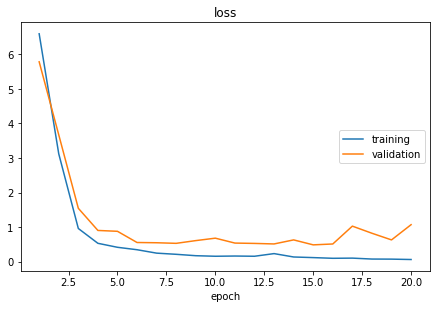

loss:
training   (min:    0.061, max:    6.596, cur:    0.061)
validation (min:    0.485, max:    5.785, cur:    1.069)




Confusion matrix, without normalization
Best valid loss 0.49071656689047816


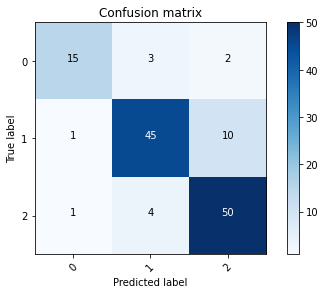

In [7]:
%time
# %load_ext autoreload
# Reference
# https://medium.com/@hasithsura/audio-classification-d37a82d6715
# path = PROJECT_PATH+"over9000"
# %cd "{path}"
# from radam import *

# from over9000 import *
# neptune.get_experiment('pytorch-densenet201-RAdam')

def eval(valid_loader, model, loss_compute, plot_matrix):
  model.eval()

  whole_loss = []
  whole_output = []
  whole_label = []

  with torch.no_grad():
    for batch_idx, (data,label) in enumerate(tq(valid_loader)):
      # optimizer.zero_grad()
      data, label = data.to(device, dtype=torch.float32), label.to(device)
      
      output = model(data)
      # print(output.shape)
      loss = loss_compute(output,label)
      whole_loss.append(loss.item())
      if plot_matrix:
        whole_output.append(output.cpu().detach().numpy())
        whole_label.append(label.cpu().detach().numpy())

  if plot_matrix:
    whole_label = np.concatenate(whole_label)
    whole_output = np.concatenate(whole_output)
    whole_output = whole_output.argmax(axis=1)

  # print(whole_output.shape)
  # valid_loss.append(np.mean(whole_loss))
  # print("Epoch",i,"val loss",valid_loss[-1])
  
  # accuracy = np.mean(whole_label == whole_output)

  if plot_matrix == True:
    plot_confusion_matrix(confusion_matrix(whole_label,whole_output),[str(x) for x in range(3)])

  return np.mean(whole_loss)

def train(epochs,data_loader,valid_loader,model,lr,best_wt_name):
  liveplot = PlotLosses(skip_first=0)
  # Optimizer Reference
  # https://github.com/mgrankin/over9000
  optimizer = optim.Adam(model.parameters(),lr=lr)
  # optimizer = RAdam(model.parameters(),lr=lr)
  loss_compute = nn.CrossEntropyLoss()

  best_model = {'loss':100, 'path':PROJECT_PATH + "data/models/pytorchnb/" + best_wt_name}
  # best_accuracy = 0

  for i in tq(range(1,epochs+1)):
    model.train()

    whole_loss = []
    for batch_idx, (data,label) in enumerate(tq(data_loader)):
      optimizer.zero_grad()
      # print(batch_idx,data.shape)
      data, label = data.to(device, dtype=torch.float32), label.to(device)
      output = model(data)
      loss = loss_compute(output,label)
      loss.backward()

      whole_loss.append(loss.item())
      # print(loss.item())
      optimizer.step()
    
    train_loss = np.mean(whole_loss)
    # print("Epoch",i,"train loss",train_loss[-1])

    valid_loss = eval(valid_loader,model,loss_compute,False)

    if best_model['loss'] > valid_loss:
      best_model['loss'] = valid_loss
      torch.save(model.state_dict(),best_model['path'])
      # best_model[PROJECT_PATH + "models/" + best_wt_tename]

    # valid_loss.append(loss)
    # print("Accuracy",accuracy)
    # print("------------------------------------------------------------")

    liveplot.update({
        'loss': train_loss,
        'val_loss': valid_loss,
        # 'val_accuracy' : accuracy
    })
    liveplot.draw()
    neptune.log_metric('val_loss', valid_loss)
    neptune.log_metric('train_loss', train_loss)

  # Confusion matrix of the best model
  model.load_state_dict(torch.load(best_model['path']))
  loss = eval(valid_loader,model,loss_compute,True)
  print("Best valid loss",loss)
  return model
  

def trainCNN(epochs,data_loader,valid_loader,model_name,pretrained,best_wt_name,lr):
  # https://github.com/rwightman/pytorch-image-models
  model = create_model(model_name, pretrained=True)
  model.classifier.out_features = 3
  model = model.to(device)
  # model.load_state_dict(torch.load(PROJECT_PATH+"data/models/pytorchnb/" + best_wt_name))
  # print(model)
  return train(epochs,data_loader,valid_loader,model,lr,best_wt_name)
  # return model


model_name = 'tf_efficientnet_b6'
PARAMS = {'learning_rate' : 1e-4,
          'n_epochs' : 20,
          'optimizer' : 'Adam',
          'model' : model_name
          }
neptune.create_experiment(name='pytorch-'+model_name+'-Adam', params=PARAMS)
model = trainCNN(PARAMS['n_epochs'],train_loader,valid_loader,model_name,True,model_name,PARAMS['learning_rate'])

# Predict

In [8]:
import torch.nn.functional as F

def predict(valid_loader, model):
  model.eval()

  # whole_loss = []
  whole_output = []
  whole_img_paths = []

  loss_compute = nn.CrossEntropyLoss()

  with torch.no_grad():
    for batch_idx, (data,label, paths) in enumerate(tq(valid_loader)):
      # optimizer.zero_grad()
      data, label = data.to(device, dtype=torch.float32), label.to(device)
      # print(len(paths))
      output = model(data)
      # print(output.shape)
      loss = loss_compute(output,label)
      # whole_loss.append(loss.item())
      # print(output.shape)
      whole_output.append(output.cpu().detach().numpy())
      # print("whole")
      whole_img_paths += paths
      # print("Whole",whole_output.shape)
      # whole_label.append(label.cpu().detach().numpy())

  # whole_label = np.concatenate(whole_label)
  whole_output = np.concatenate(whole_output)
  # print(whole_output.shape)
  # valid_loss.append(np.mean(whole_loss))
  # print("Epoch",i,"val loss",valid_loss[-1])
  # whole_output = whole_output.argmax(axis=1)
  # accuracy = np.mean(whole_label == whole_output)
  probs = F.softmax(torch.from_numpy(whole_output), dim=1)

  return whole_img_paths, probs

preds_path,preds_prob = predict(test_loader, model)

# Make Submission

In [9]:
import os
test_path = PROJECT_PATH+"data/test/test"
# test_path = PROJECT_PATH + "/other-data/test/"
# print(model.data.classes)
# submission = pd.DataFrame({'ID': [s.split('.')[0] for s in os.listdir(test_path)  if s.split('.')[1] != 'jfif']})
submission = pd.DataFrame({'ID': preds_path})
# submission
for i, c in enumerate(['healthy_wheat', 'leaf_rust', 'stem_rust']):
  # print(preds_test[:,i].shape)
  # print(c)
  submission[c] = preds_prob[:,i]
submission = submission[['ID', 'leaf_rust', 'stem_rust', 'healthy_wheat']] # Get same order as sample sub
submission

,ID,leaf_rust,stem_rust,healthy_wheat
0,008FWT,0.495177,0.415229,0.021605
1,00AQXY,0.124745,0.852017,0.001173
2,01OJZX,0.495177,0.415229,0.021605
3,07OXKK,0.000274,0.000003,0.993217
4,085IEC,0.003031,0.428411,0.523635
...,...,...,...,...
605,ZKF0L9,0.555126,0.004454,0.419117
606,ZMAB3R,0.000312,0.996817,0.000056
607,ZOXDKA,0.008879,0.966015,0.000477
608,ZSZMOS,0.000834,0.996257,0.000586


In [0]:
submission.to_csv(PROJECT_PATH+'submissions/'+model_name+'_augment_adam_pytorch_submission.csv', index = False)